## Diabetes Classification - Principal Components Analysis (PCA)

### Autor: Antonio Castañares Rodríguez

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is a linear dimesionality technique that can be used to simplify a dataset by reducing the number of dimensions (number of features). 

The idea of PCA is to find directions in the data where the variance is maximized. For this reason, PCA transform the original data into principal components (new dimesions that capture the most important patterns in the data).

#### Variance and covariance:

We use the variance to measure 'the most important patterns'. The variance gives us how much our data spread out or varies from its own mean.

$$
variance = \frac{1}{N} *\sum^{N}_{i=1}(x_i - \hat{x})^2
$$

In matrix form:

$$
variance = \frac{1}{N} * (X - \hat{X})^2
$$

Where:
- N: is the number of samples.
- X: is the matrix of features.
- $\hat{x}$: is the mean of each feature

Futhermore, covariance is must be use in PCA. Covariance means whether two variables moves in the same direction. We calculate the covariance matrix to identify relations between features so the algorithm can rotate the data and drop unimportant dimensions.

$$
\text{Covariance matrix} = \frac{1}{N}X^TX
$$

#### Eigenvalues and eigenvectors:

In PCA, eigenvectors are our principal components (final dimensions), meanwhile eigenvalues are how much variance is in that direction. Therefore, we select the highest eigenvector with the highest eigenvalues. Normally, we calculate eigenvalues first, and them we calculate eigenvectors using the following equation:

$$
A * v = \lambda * v \\
A * v - \lambda * v = 0 \\
(A - \lambda * I)v = 0
$$

Where:
- A: is our covariance matrix
- v: are our eigenvectors
- $\lambda$: are our eigenvalues

To solve it for a non-zero 'v', we must to solve $det(A - \lambda I) = 0$. Solving this would give us the eigenvalues and them we can calculate the eigenvectors

Finally, we must reduce the dimensions while keeping the variance by projecting the data

$$
X_{new} = X_{old} * W_k
$$

Where: 
- X_new: is the data with the new dimension (n_samples,k_eigenvalues)
- X_old: is the previous data (n_samples,n_features)
- W_k: is the matrix with top k eigenvectors (n_features,k_eigenvalues)

#### Step to calculate PCA:

1. Standardize the data
2. Compute the covariance matrix
3. Compute eigenvalues and eigenvectors
4. Sort eigenvectors by eigenvalues in descending order
5. Project the data


In [18]:
class my_PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.eigenvectors = None
    
    def fit(self,X):
        # Standardize the data
        mean = np.mean(X, axis = 0) # Mean of each column
        n_samples = X.shape[0] # Number of samples
        X_centered = X - mean

        # Calculate the covariance matrix
        covariance_matrix = X_centered.T @ X_centered / (n_samples)

        # Calculate eigenvalues and eigenvectors
        eigenvalues, self.eigenvectors = np.linalg.eig(covariance_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]

        # Select the top n_components eigenvectors
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        eigenvalues = eigenvalues[:self.n_components]
        
        return self.eigenvectors, eigenvalues
    
    def transform(self, X):
        # Project the data onto the new feature space
        mean = np.mean(X, axis = 0)
        X_centered = X - mean

        return X_centered @ self.eigenvectors

### Diabetes dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Description of each feature:
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

In [19]:
df = pd.read_csv('diabetes.csv')

In [20]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
print(f'Number of missing values in each column: \n{df.isnull().sum()}')

Number of missing values in each column: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


We have 8 input features and one target feature. The dataset does not have missing values and the types of each column seems correct.

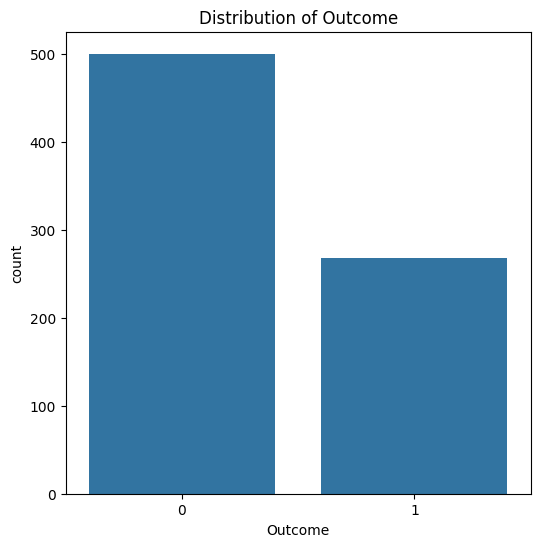

Number total of patients: 768
Number of patients with diabetes: 268
Number of patients without diabetes: 500
Percentage of patients with diabetes: 34.90%


In [23]:
plt.figure(figsize=(6, 6))
plt.title('Distribution of Outcome')
sns.countplot(x='Outcome', data=df)
plt.show()

print(f'Number total of patients: {df.shape[0]}')
print(f'Number of patients with diabetes: {df[df["Outcome"] == 1].shape[0]}')
print(f'Number of patients without diabetes: {df[df["Outcome"] == 0].shape[0]}')
print(f'Percentage of patients with diabetes: {df[df["Outcome"] == 1].shape[0] / df.shape[0] * 100:.2f}%')

The dataset is imbalanced as only 34,9% of the samples belongs to diabetes class. Normally, I use technique to balanced the dataset like oversampling the minority class or undersampling the majority class. However, PCA is an unsupervised (it does not use the target). For this reason, I decided do not apply resampling approaches.

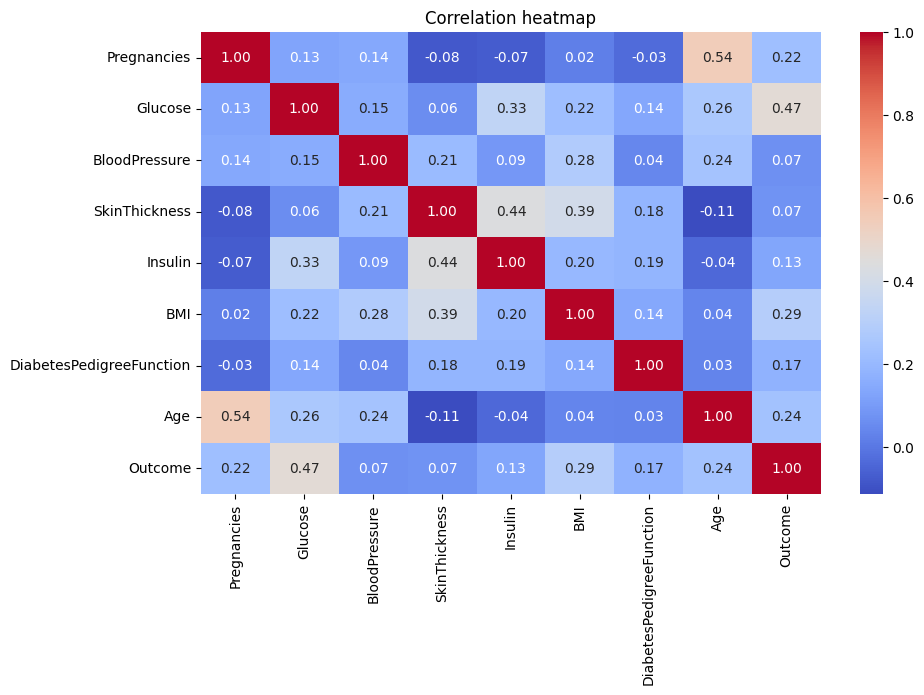

In [24]:
plt.figure(figsize=(10, 6))
plt.title('Correlation heatmap')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

It seems the most relevant features for Outcome (target) are Glucose, BMI, age, and Pregnancies because their correlations are higher with Outcome than BloodPressure or SkinThickness. Other interesting relations are for example SkinThickness with Insulin (0.44) or Pregnancies and Age (0.54), suggesting that we might consider omitting one feature in each case depending on model performance or redundancy.

#### Principal Components Analysis (PCA)

Remember PCA is a unsupervised method, let's separate the target from the features and compare the performance of my implementation with sklearn PCA method.

In [25]:
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

In [26]:
my_pca = my_PCA(n_components=4) # My implementation
my_eigenvectors, my_eigenvalues = my_pca.fit(X)
X_my_pca = my_pca.transform(X)

In [27]:
pca = PCA(n_components=4) # Sklearn implementation
X_pca = pca.fit_transform(X)

The comparison is based on the variance explained by each implementation. Recall that PCA aims to maximize the variance captured by the principal components, as this reflects the ability to represent the most information using fewer dimensions.

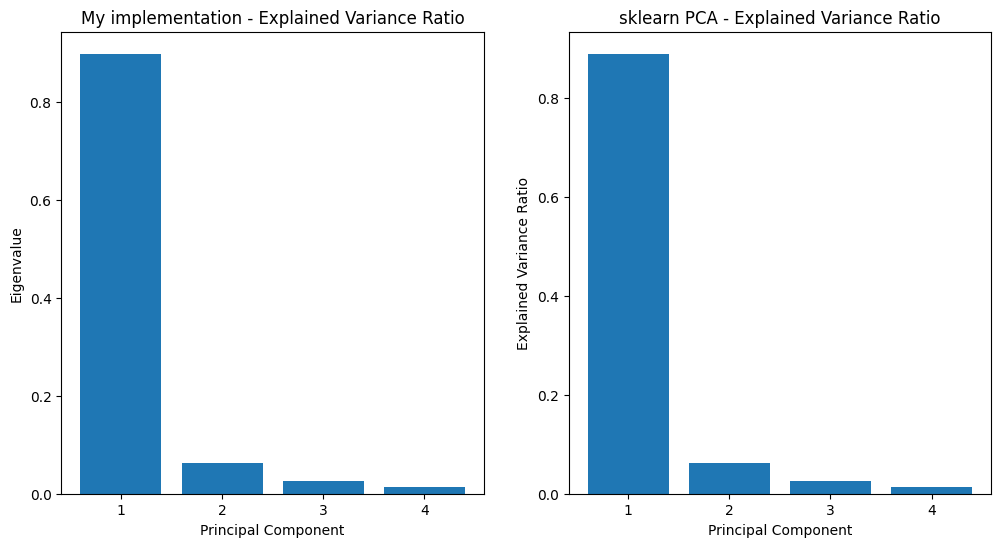

Explained variance ratio of my implementation: [0.89841694 0.06227496 0.0260766  0.0132315 ]
Explained variance ratio of sklearn PCA: [0.88854663 0.06159078 0.02579012 0.01308614]
Total explained variance of my implementation: 0.9999999999999999
Total explained variance of sklearn PCA: 0.989013674654303


In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('My implementation - Explained Variance Ratio')
plt.bar(range(1, len(my_eigenvalues) + 1), my_eigenvalues/np.sum(my_eigenvalues))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(my_eigenvalues) + 1))

plt.subplot(1, 2, 2)
plt.title('sklearn PCA - Explained Variance Ratio')
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

print(f'Explained variance ratio of my implementation: {my_eigenvalues/np.sum(my_eigenvalues)}')
print(f'Explained variance ratio of sklearn PCA: {pca.explained_variance_ratio_}')
print('Total explained variance of my implementation:', np.sum(my_eigenvalues/np.sum(my_eigenvalues)))
print('Total explained variance of sklearn PCA:', np.sum(pca.explained_variance_ratio_))

In [29]:
print(f'Eigenvalues of my implementation: {my_eigenvalues}')
print(f'Eigenvalues of sklearn PCA: {pca.explained_variance_}')

Eigenvalues of my implementation: [13439.05140161   931.54560089   390.06926626   197.92464067]
Eigenvalues of sklearn PCA: [13456.57298102   932.76013231   390.57783115   198.18269105]


My results show that my PCA implementation closely matches scikit-learn's. The explained variance ratios are nearly identical across all four components, with mu version capturing slightly more total variance (≈1.0 vs. ≈0.989). Overall, my PCA implementation is highly accurate and performs on par.

#### XGBoost

Finally, I'm gonna use XGBoost Classifier. XGBoost is an ensemble model based on gradient boosting, meaning: 

1) Builds models sequentially, each correcting the errors of the previous one.
2) Each model is usually a decision tree 
3) It minimizes a loss function using gradient descent

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42) 

In [38]:
# Initialize and train the XGBoost model
model = XGBClassifier(scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), # Handle class imbalance
                        n_estimators = 300,                                         # Number of trees
                        max_depth = 3,                                              # Maximum depth of trees
                        learning_rate = 0.05,                                       # Learning rate
                        subsample = 0.8,                                            # Fraction of samples to use for each tree
                        colsample_bytree = 0.8,                                     # Fraction of features to use for each tree
                        reg_lambda = 1)                                             # L2 regularization term (avoid overfitting)                                       

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

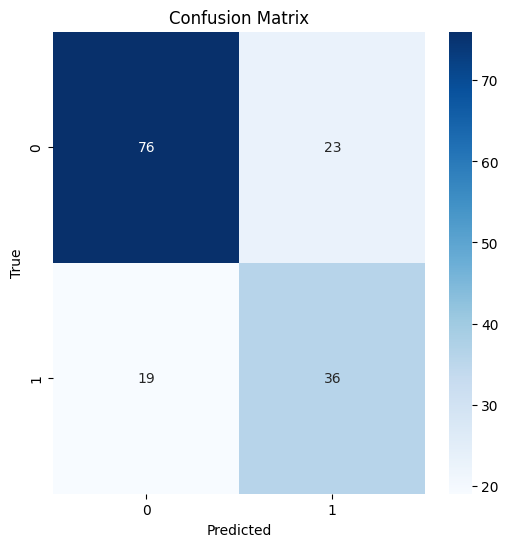

Accuracy of XGBoost model: 0.73
              precision    recall  f1-score   support

           0       0.80      0.77      0.78        99
           1       0.61      0.65      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



In [39]:
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of XGBoost model: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

The results show a reasonably balanced performance, with the model achieving an overall accuracy of 0.73. It handles the majority class well, but its performance on the diabetic class is noticeably weaker. While the F1-score for both classes is fairly close, the recall for class 1 suggests that the model misses a significant number of diabetic cases. Overall, the model is doing a decent job, but there's a clear gap in detecting positives that holds it back from being truly reliable for a health-sensitive application.